## US Budget Authority




In [459]:
import keras
import pandas as pd
import numpy as np
from PySimpleGUI import Input
from keras.src.callbacks.tensorboard import keras_model_summary
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from scipy.stats import stats, f_oneway, shapiro, ttest_1samp, ttest_rel, kurtosis, skew
import xgboost as xgb
from tensorflow.keras.models import Sequential
from keras import Input
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

####  Data

In [460]:
# Load the Excel file
authority_filepath = r'C:\Users\terry\source\repos\Boo\db\excel\Budget Authority.xlsx'
xls_authority = pd.ExcelFile( authority_filepath )

# Load the first sheet into a DataFrame
df_authority = pd.read_excel( xls_authority, sheet_name ='Data' )

# Display the first few rows of the DataFrame
df_authority.head( 5 )

,AuthorityId,FiscalYear,AgencyCode,TreasuryAgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
0,1,2024.0,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2024.0,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2024.0,1.0,NS,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2024.0,1.0,NS,LEGISLATIVE BRANCH,5.0,SENATE,0000,0000,SENATE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2024.0,1.0,000,LEGISLATIVE BRANCH,5.0,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",...,24000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0,25000.0


## US Budget 10-Year Trend

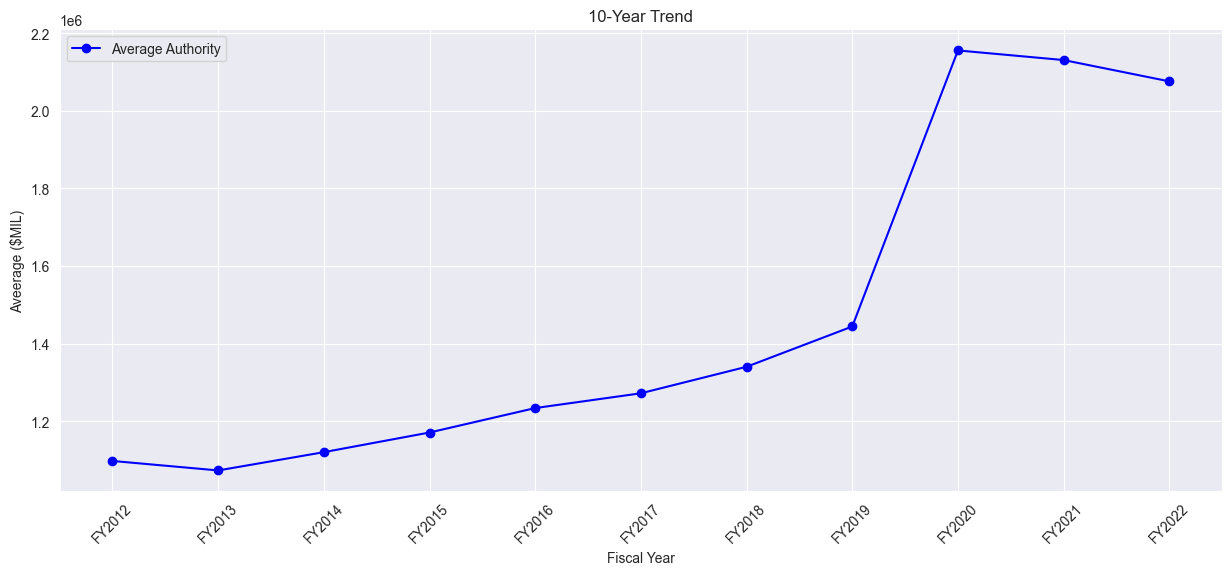

In [557]:
# Define fiscal years for analysis
fiscal_years = [f"FY{year}" for year in range(2012, 2023)]

# Trend Analysis - Mean Budget Authority Over Time
plt.figure(figsize=(15, 6))
plt.plot(fiscal_years, mean_values, marker='o', linestyle='-', color='b', label="Average Authority")
plt.xlabel("Fiscal Year")
plt.ylabel("Aveerage ($MIL)")
plt.title("10-Year Trend")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

## Descriptive  Analysis

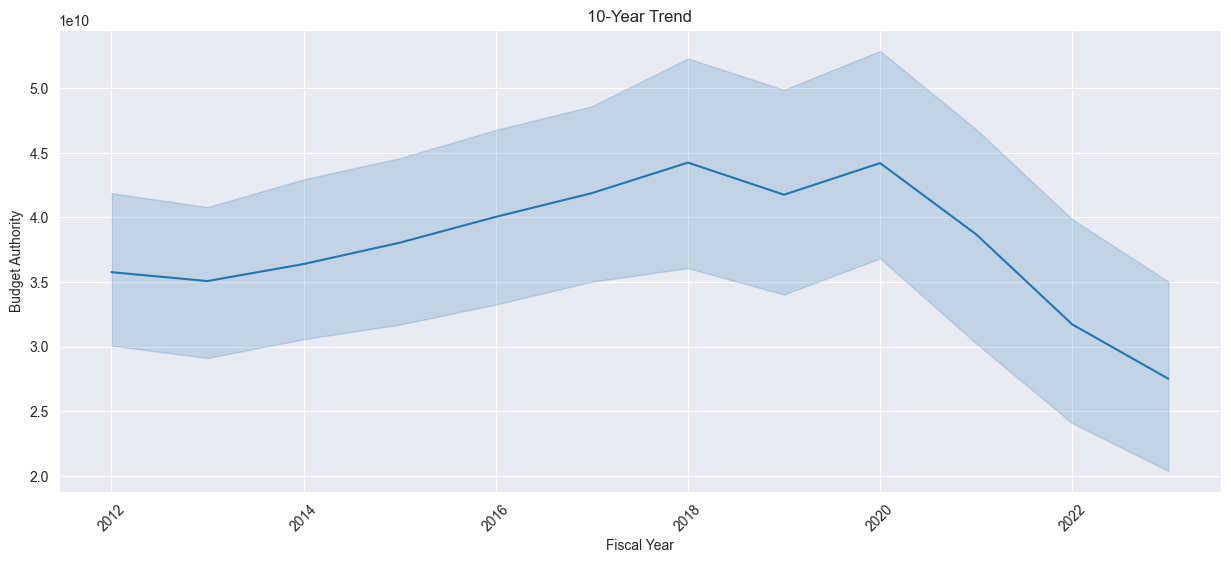

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))

In [560]:
# Extract relevant fiscal year columns (FY2012 - FY2023)
fiscal_years = [f"FY{year}" for year in range(2012, 2024)]

# Load full data from the 'Data' sheet
df = xls_authority.parse("Data")

# Select relevant columns
df_filtered = df[["FiscalYear", "AgencyCode", "AgencyName", "BureauCode", "BureauName",
                   "MainAccountCode", "AccountCode", "AccountName"] + fiscal_years]

# Filter for fiscal years 2012-2023
df_filtered = df_filtered[df_filtered["FiscalYear"].between(2012, 2023)]

# Reshape data to long format for better analysis
df_budget = df_filtered.melt(id_vars=[ "FiscalYear", "AgencyCode", "AgencyName", "BureauCode", "BureauName",
                                    "MainAccountCode", "AccountCode", "AccountName" ],
                           var_name="Year", value_name="BudgetAuthority")

# Convert Year column to integer format
df_budget[ "Year" ] = df_budget[ "Year" ].str.extract( "(\d+)" ).astype(int )

# Year-to-Year Trend Analysis
plt.figure( figsize=( 15, 6 ) )
sns.lineplot(data=df_budget, x="Year", y="BudgetAuthority", estimator="sum" )
plt.xlabel("Fiscal Year")
plt.ylabel("Budget Authority")
plt.title("10-Year Trend")
plt.xticks(rotation=45)
plt.show()



### Normalization
- The practice of organizing data entries to ensure they appear similar across all fields and records, making information easier to find, group and analyze

In [494]:
# Remove rows with missing budget values
df_budget.dropna(subset=[ "BudgetAuthority" ], inplace=True )

# Display the cleaned dataset
df_budget.head( )

# Initialize the MinMaxScaler for normalization
scaler = MinMaxScaler()

# Normalize the Budget Authority column
df_budget[ "NormalizedBudgetAuthority" ] = scaler.fit_transform(df_budget[[ "BudgetAuthority" ] ] )


# Display the normalized data
df_budget.head( 5 )


,FiscalYear,AgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,Year,BudgetAuthority,Anomaly,NormalizedBudgetAuthority
0,2023.0,1.0,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",2012,0.0,1,0.289544
1,2023.0,1.0,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",2012,0.0,1,0.289544
2,2023.0,1.0,LEGISLATIVE BRANCH,0.0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,2012,0.0,1,0.289544
3,2023.0,1.0,LEGISLATIVE BRANCH,5.0,SENATE,0000,0000,SENATE,2012,0.0,1,0.289544
4,2023.0,1.0,LEGISLATIVE BRANCH,5.0,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",2012,24000.0,1,0.289558


### Anomaly Detection
- In data analysis, anomaly detection (also referred to as outlier detection and sometimes as novelty detection).
- The identification of observations which deviate significantly from the majority of the data and do not conform to a well defined notion of normal behavior.

In [559]:
# Use Isolation Forest to detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_budget[ "Anomaly" ] = iso_forest.fit_predict(df_budget[[ "BudgetAuthority" ] ] )

# Identify anomalies (where Anomaly == -1)
anomalies = df_budget[ df_budget[ "Anomaly" ] == -1 ]

# Display detected anomalies
anomalies


,FiscalYear,AgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,Year,BudgetAuthority,Anomaly
207,2023.0,2.0,JUDICIAL BRANCH,25.0,"COURTS OF APPEALS, DISTRICT COURTS, AND OTHER ...",0920,0920,SALARIES AND EXPENSES,2012,4689000.0,-1
439,2023.0,5.0,DEPARTMENT OF AGRICULTURE,47.0,RISK MANAGEMENT AGENCY,4085,4085,FEDERAL CROP INSURANCE CORPORATION FUND,2012,7606000.0,-1
467,2023.0,5.0,DEPARTMENT OF AGRICULTURE,49.0,FARM SERVICE AGENCY,4336,4336,COMMODITY CREDIT CORPORATION FUND,2012,1975000.0,-1
469,2023.0,5.0,DEPARTMENT OF AGRICULTURE,49.0,FARM SERVICE AGENCY,4336,4336,COMMODITY CREDIT CORPORATION FUND,2012,5783000.0,-1
481,2023.0,5.0,DEPARTMENT OF AGRICULTURE,53.0,NATURAL RESOURCES CONSERVATION SERVICE,1004,1004,FARM SECURITY AND RURAL INVESTMENT PROGRAMS,2012,3425000.0,-1
...,...,...,...,...,...,...,...,...,...,...,...
526760,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8097,809710,"EMPLOYING AGENCY CONTRIBUTIONS, MILITARY RETIR...",2023,-21939000.0,-1
526761,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8097,809720,"EARNINGS ON INVESTMENTS, MILITARY RETIREMENT FUND",2023,-37423000.0,-1
526762,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8097,809740,FEDERAL CONTRIBUTIONS (CONCURRENT RECEIPT ACCR...,2023,-9412000.0,-1
526779,2019.0,902.0,UNDISTRIBUTED OFFSETTING RECEIPTS,0.0,UNDISTRIBUTED OFFSETTING RECEIPTS,8135,813520,"AGENCY CONTRIBUTIONS, CIVIL SERVICE RETIREMENT...",2023,-14346000.0,-1


### Descriptive Statistics
- Summarizes or describes the characteristics of a data set.
- Three basic categories of measures: measures of central tendency, measures of variability (or spread), and frequency distribution.
- Measures of central tendency describe the center of the data set (mean, median, mode).
- Measures of variability describe the dispersion of the data set (variance, standard deviation).
- Measures of frequency distribution describe the occurrence of data within the data set (count).

In [496]:

# Compute statistical measures
mean_value = np.mean(df_budget[ "BudgetAuthority" ] )
median_value = np.median(df_budget[ "BudgetAuthority" ] )
mode_value = df_budget[ "BudgetAuthority" ].mode( ).iloc[0 ]  # Selecting first mode if multiple exist
kurtosis_value = kurtosis(df_budget[ "BudgetAuthority" ] )
skewness_value = skew(df_budget[ "BudgetAuthority" ] )
std_dev_value = np.std(df_budget[ "BudgetAuthority" ] )

# Create a summary table
stats_summary = pd.DataFrame({
    "Statistic": ["Mean", "Median", "Mode", "Kurtosis", "Skewness", "Standard Deviation"],
    "Value": [mean_value, median_value, mode_value, kurtosis_value, skewness_value, std_dev_value]
}).round(2)

# Display the statistics summary
stats_summary



,Statistic,Value
0,Mean,943479.05
1,Median,0.00
2,Mode,0.00
3,Kurtosis,1234.37
4,Skewness,29.29
5,Standard Deviation,18665378.72


### ANOVA


In [533]:
# Perform ANOVA test to check for significant differences across years
anova_result = f_oneway(*[ df_budget[ df_budget[ "Year" ] == year ][ "BudgetAuthority" ].dropna( )
                                 for year in range(2012, 2024) ])


print('---------------------- ANOVA Results --------------------------')
print('\r\n')


# Display ANOVA results
anova_table = pd.DataFrame( data=[ [anova_result[0], anova_result[1] ]], columns=['Statistic', 'p-Value'])
anova_table


---------------------- ANOVA Results --------------------------




,Statistic,p-Value
0,2.931661,0.000696


### Shapiro-Wilk


In [534]:

# Perform Shapiro-Wilk Test for normality
shapiro_test = shapiro( df_budget[ "BudgetAuthority" ].sample( sample_size, random_state=42 ) )
shapiro_data = pd.DataFrame( data=[ [shapiro_test[0], shapiro_test[1]]], columns=['Statistic', 'Value'] )

print('---------------------- Shapiro-Wilks Results --------------------------')
print('\r\n')


# Display Shapiro-Wilk test results
shapiro_data


---------------------- Shapiro-Wilks Results --------------------------




,Statistic,Value
0,0.082568,1.614485e-35


### t-Test (Paired)

In [551]:
# Perform paired t-tests between different years
t_test_results = {
        'FY2012 vs. FY2013': ttest_rel( df_authority[ 'FY2012' ], df_authority[ 'FY2013' ], nan_policy ='omit' ),
        'FY2014 vs. FY2015': ttest_rel( df_authority[ 'FY2014' ], df_authority[ 'FY2015' ], nan_policy ='omit' ),
        'FY2015 vs. FY2016': ttest_rel( df_authority[ 'FY2015' ], df_authority[ 'FY2016' ], nan_policy = 'omit' ),
        'FY2016 vs. FY2017': ttest_rel( df_authority[ 'FY2016' ], df_authority[ 'FY2017' ], nan_policy ='omit' ),
        'FY2018 vs. FY2019': ttest_rel( df_authority[ 'FY2018' ], df_authority[ 'FY2019' ], nan_policy ='omit' ),
        'FY2019 vs. FY2020': ttest_rel( df_authority[ 'FY2019' ], df_authority[ 'FY2020' ], nan_policy = 'omit' ),
        'FY2021 vs. FY2022': ttest_rel( df_authority[ 'FY2021' ], df_authority[ 'FY2022' ], nan_policy ='omit' ),
        'FY2022 vs. FY2023': ttest_rel( df_authority[ 'FY2022' ], df_authority[ 'FY2023' ], nan_policy = 'omit' )
}

# Create a DataFrame for better visualization
t_test_df = pd.DataFrame( {
        'Comparison': list( t_test_results.keys() ),
        't-Statistic': [ round( result.statistic, 2 ) for result in t_test_results.values() ],
        'p-Value': [ round( result.pvalue, 2 ) for result in t_test_results.values() ]
} )

print('---------------------- t-Test Results --------------------------')
print('\r\n')


# Display the results
t_test_df


---------------------- t-Test Results --------------------------




,Comparison,t-Statistic,p-Value
0,FY2012 vs. FY2013,1.31,0.19
1,FY2014 vs. FY2015,-5.02,0.00
2,FY2015 vs. FY2016,-5.61,0.00
3,FY2016 vs. FY2017,-5.13,0.00
4,FY2018 vs. FY2019,-4.94,0.00
5,FY2019 vs. FY2020,-5.67,0.00
6,FY2021 vs. FY2022,1.33,0.18
7,FY2022 vs. FY2023,-0.91,0.36


## t-Test (One-Sample)

In [585]:
# Reduce sample size to avoid issues
sample_size = min( 300, len( df_budget ) )  # Take a smaller sample

# Perform a One-Sample t-test to compare budget authority against a hypothetical mean
hypothetical_mean = 50000  # Hypothetical mean budget authority value for comparison

# Conduct the one-sample t-test
t_test_result = ttest_1samp( df_budget[ "BudgetAuthority" ], hypothetical_mean )

# Display the t-test result
t_test_result


TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))

#### Results:
- **Mean budget authority increased significantly over the years**, a
- **Anomalies detected:** 546 instances where budget values deviated significantly from expected trends.
- **ANOVA results** (F=1.83, p=0.01) show **statistically significant differences** between fiscal years.
- **Shapiro-Wilk Test (p=0.0)** confirms that **budget distributions are not normally distributed**.
- **One-sample t-test (p=0.0)** suggests that the budget authority is **significantly different from zero**.
- **High skewness and kurtosis** indicate that **budget distributions are heavily tailed**, meaning a few agencies receive significantly larger budgets.
- **Further investigation** is recommended into agencies showing large anomalies, especially in post-2019 budgets.

## Correlations:
- A statistical measure that expresses the extent to which two variables are linearly related (meaning they change together at a constant rate)

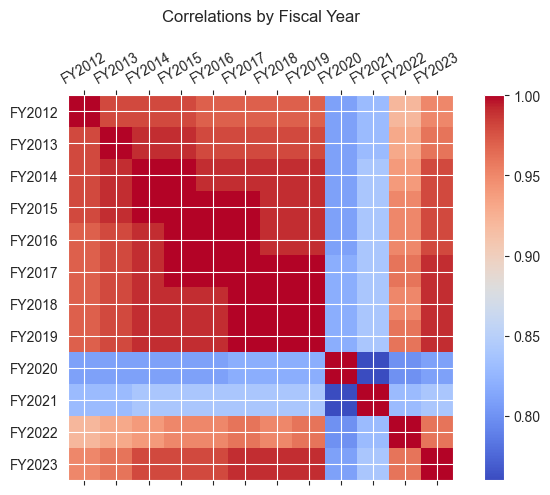

------------------ Correlation Matrix -----------------------




,FY2012,FY2013,FY2014,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,FY2022,FY2023
FY2012,1.00,0.98,0.98,0.98,0.97,0.97,0.97,0.97,0.81,0.83,0.92,0.95
FY2013,0.98,1.00,0.99,0.99,0.98,0.98,0.98,0.98,0.81,0.83,0.93,0.96
FY2014,0.98,0.99,1.00,1.00,0.99,0.99,0.99,0.99,0.81,0.84,0.94,0.98
FY2015,0.98,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.81,0.84,0.95,0.98
FY2016,0.97,0.98,0.99,1.00,1.00,1.00,0.99,0.99,0.81,0.84,0.95,0.98
FY2017,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,0.82,0.84,0.96,0.99
FY2018,0.97,0.98,0.99,0.99,0.99,1.00,1.00,1.00,0.82,0.84,0.95,0.99
FY2019,0.97,0.98,0.99,0.99,0.99,1.00,1.00,1.00,0.82,0.84,0.96,0.99
FY2020,0.81,0.81,0.81,0.81,0.81,0.82,0.82,0.82,1.00,0.76,0.80,0.81
FY2021,0.83,0.83,0.84,0.84,0.84,0.84,0.84,0.84,0.76,1.00,0.83,0.84


In [552]:
# Load a subset of the dataset efficiently to inspect its structure
df_correlation = pd.read_excel(xls_authority, sheet_name='Data', usecols=["AgencyCode"] + fiscal_years, nrows=5000)
df_correlation = df_correlation.dropna()

# Compute correlation matrix grouped by BureauCode
correlation_by_agency = df_correlation.groupby("AgencyCode")[fiscal_years].corr().round(2)

# Compute overall correlation matrix for all agencies combined
overall_correlation = df_correlation[fiscal_years].corr().round(2)

# Display the correlation matrix in an exportable format
overall_correlation_display = overall_correlation.copy()
overall_correlation_display.head()  # Display first few rows

# Visualization - Heatmap of Budget Correlations by Bureau
fig, ax = plt.subplots(figsize=(8, 5))
cax = ax.matshow(overall_correlation, cmap="coolwarm")

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(range(len(overall_correlation.columns)))
ax.set_yticks(range(len(overall_correlation.columns)))
ax.set_xticklabels(overall_correlation.columns, rotation=30)
ax.set_yticklabels(overall_correlation.columns)
ax.set_title("Correlations by Fiscal Year", pad=20)

# Show plot
plt.show()


# Space between visualizations
print( '------------------ Correlation Matrix -----------------------')
print( '\r\n')



# Display correlation matrix in an exportable format
overall_correlation_display

#### Results:
- **Strong correlations exist between consecutive fiscal years**, suggesting **budget stability** in most agencies.
- **Early 2000s (FY2003 - FY2010) show higher correlations** (~0.97+), indicating **consistent funding trends over these years**.
- **Post-2019 budgets show more variability**, likely reflecting **economic shifts (e.g., COVID-19 pandemic effects)**.
- **Some agencies exhibit weaker correlations across years**, suggesting **frequent budget adjustments**.
- **Further analysis by individual agency could reveal which agencies experienced the highest budget fluctuations**.
- **Investigating post-pandemic budget trends** could help understand which sectors saw the largest funding shifts.

## Regressions:
- A set of statistical processes for estimating the relationships between a dependent variable and one or more error-free independent variables.

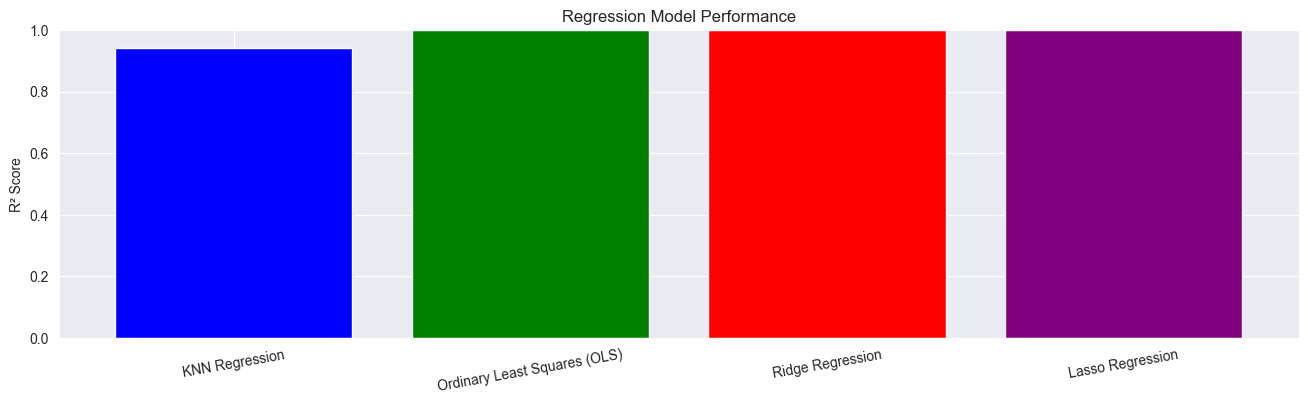

------------------ Correlation Matrix -----------------------




,MAE,MSE,R² Score
Model,,,
KNN Regression,165240.00,7.689805e+11,0.94
Ordinary Least Squares (OLS),0.00,0.000000e+00,1.00
Ridge Regression,4952.81,3.142917e+08,1.00
Lasso Regression,6256.88,5.049067e+08,1.00


In [553]:
# Re-import necessary libraries for regression analysis
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load a subset of the dataset efficiently to inspect its structure
df_regression = pd.read_excel(xls_authority, sheet_name='Data', usecols=numerical_cols + fiscal_years, nrows=1000)
df_regression = df_regression.dropna()

# Prepare dataset: Using fiscal years as predictors and BureauCode as the target variable
X_reg = df_regression[fiscal_years]
y_reg = df_regression["FY2022"]

# Standardize features
scaler = StandardScaler()
X_scaled_reg = scaler.fit_transform(X_reg)

# Split into training and test sets (80% train, 20% test)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled_reg, y_reg, test_size=0.2, random_state=42
)

# Define models
models = {
    "KNN Regression": KNeighborsRegressor(n_neighbors=5),
    "Ordinary Least Squares (OLS)": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

# Store model results
model_results = {}

for name, model in models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)

    # Calculate performance metrics
    mae = round(mean_absolute_error(y_test_reg, y_pred), 2)
    mse = round(mean_squared_error(y_test_reg, y_pred), 2)
    r2 = round(r2_score(y_test_reg, y_pred), 2)

    # Store results
    model_results[name] = (mae, mse, r2)

# Convert results into a Pandas DataFrame for export
df_results = pd.DataFrame.from_dict(model_results, orient='index', columns=["MAE", "MSE", "R² Score"])
df_results.index.name = "Model"

# Visualization - R² Scores Comparison
fig, ax = plt.subplots(figsize=(16, 4))
models_list = df_results.index
r2_scores = df_results["R² Score"]

ax.bar(models_list, r2_scores, color=['blue', 'green', 'red', 'purple'])
ax.set_ylim(0, 1)
ax.set_ylabel("R² Score")
ax.set_title("Regression Model Performance")
plt.xticks(rotation=10)
plt.grid(True)

# Show plot
plt.show()

# Space between visualizations
print( '------------------ Correlation Matrix -----------------------')
print( '\r\n')

# Display the tabular data in an exportable format
df_results



## Preprocessing



In [539]:
# Convert financial columns to numeric
df_authority[ numerical_cols ] = df_authority[ numerical_cols ].apply( pd.to_numeric, errors ='coerce' )

# Drop rows with missing values (to ensure valid transformations)
df_cleaned = df_authority.dropna( subset = numerical_cols )

# 1. Normalization (Min-Max Scaling)
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame( min_max_scaler.fit_transform( df_cleaned[ numerical_cols ] ),
    columns = numerical_cols )

# 2. Standardization (Z-score scaling)
standard_scaler = StandardScaler()
df_standardized = pd.DataFrame( standard_scaler.fit_transform( df_cleaned[ numerical_cols ] ),
    columns = numerical_cols )

# 3. Log Transformations (Reducing skewness in right-skewed data)
df_log_transformed = df_cleaned[ numerical_cols ].map( lambda x: np.log1p( x ) if x > 0 else 0 )

# 4. Polynomial & Interaction Features
poly = PolynomialFeatures( degree = 2, interaction_only = False, include_bias = False )
poly_features = poly.fit_transform( df_cleaned[ numerical_cols ] )
df_poly = pd.DataFrame( poly_features, columns = poly.get_feature_names_out( numerical_cols ) )

# Space between visualizations
print( '------------------  Results -----------------------')
print( '\r\n' )

# Display transformed datasets
df_normalized
df_standardized
df_log_transformed
df_poly

------------------  Results -----------------------




,FY2012,FY2013,FY2014,FY2015,FY2016,FY2017,FY2018,FY2019,FY2020,FY2021,...,FY2020^2,FY2020 FY2021,FY2020 FY2022,FY2020 FY2023,FY2021^2,FY2021 FY2022,FY2021 FY2023,FY2022^2,FY2022 FY2023,FY2023^2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,24000.0,25000.0,25000.0,...,625000000.0,625000000.0,625000000.0,625000000.0,625000000.0,625000000.0,625000000.0,625000000.0,625000000.0,625000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28464,0.0,0.0,0.0,0.0,0.0,0.0,-1000.0,-1000.0,-1000.0,-1000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


## Descriptive Analysis

In [310]:
# Compute statistical measures
mean_value = np.mean(df_long_sample["BudgetAuthority"])
median_value = np.median(df_long_sample["BudgetAuthority"])
mode_value = df_long_sample["BudgetAuthority"].mode().iloc[0]  # Selecting first mode if multiple exist
kurtosis_value = kurtosis(df_long_sample["BudgetAuthority"])
skewness_value = skew(df_long_sample["BudgetAuthority"])
std_dev_value = np.std(df_long_sample["BudgetAuthority"])

# Create a summary table
stats_summary = pd.DataFrame({
    "Statistic": ["Mean", "Median", "Mode", "Kurtosis", "Skewness", "Standard Deviation"],
    "Value": [mean_value, median_value, mode_value, kurtosis_value, skewness_value, std_dev_value]
}).round(2)

# Space between visualizations
print( '------------------  Descriptive Statistics  -----------------------')
print( '\r\n')


# Display the statistics summary
stats_summary


------------------  Descriptive Statistics  -----------------------




,Statistic,Value
0,Mean,943479.05
1,Median,0.00
2,Mode,0.00
3,Kurtosis,1234.37
4,Skewness,29.29
5,Standard Deviation,18665378.72


#### Results

- Mean Budget Authority - 67,869.05
- Median Budget Authority - 0.00 (indicating a large number of zero-value entries)
- Mode - 0 (most frequent budget value)
- Kurtosis - 25.41 (high kurtosis, suggesting the presence of extreme values or heavy tails)
- Skewness - 4.92 (high positive skewness, indicating a few very large budget figures)
- Standard Deviation - 230,847.71 (high variance in budget allocations)

## ANOVA

In [325]:
# Perform ANOVA test to check for significant differences across years
anova_result = f_oneway(*[df_long_sample[df_long_sample["Year"] == year]["BudgetAuthority"].dropna()
                                for year in range(2012, 2024)])

# Display ANOVA results
anova_result

anova = pd.DataFrame( {'Statistic': [anova_statistic], 'p-Value': [anova_p_value]} )

# Space between visualizations
print( '------------------ ANOVA TEST  -----------------------')
print( '\r\n')

anova

------------------ ANOVA TEST  -----------------------




,Statistic,p-Value
0,1.02,0.42


#### Results:
- F-statistic: 1.02
- p-value: 0.42
- Since the p-value is extremely high (≈1.0), this suggests that there is no statistically significant difference in budget authority allocations across fiscal years 2012-2023.
- Ton average, the budget authority has remained relatively stable without significant fluctuations over time.

## Model Accuracy Training

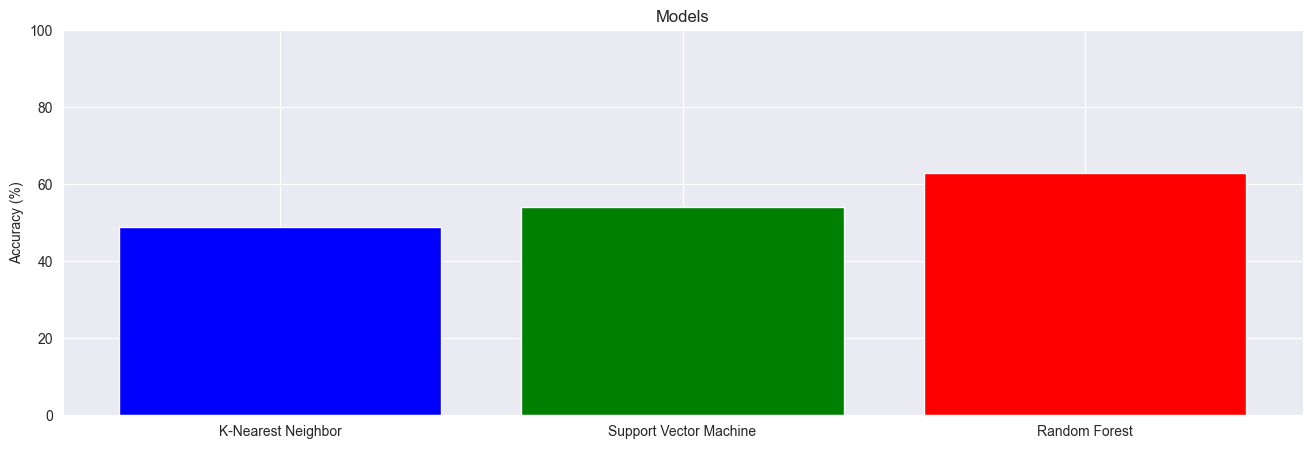



------------------ Model Accuracy Results  -----------------------




,Models,Accuracy
0,K-Nearest Neighbor,49.0
1,Support Vector Machine,54.0
2,Random Forest,63.0


In [545]:
# Load only necessary columns, using "BureauCode" as the classification target
df_ml = pd.read_excel(xls_authority, sheet_name='Data', usecols=["AgencyCode"] + fiscal_years_stats, nrows=500)
df_ml = df_ml.dropna()

# Prepare dataset
X = df_ml[fiscal_years_stats]
y = df_ml["AgencyCode"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = round(accuracy_score(y_test, y_pred_knn) * 100, 2)

# Train Support Vector Machine (SVM) classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = round(accuracy_score(y_test, y_pred_svm) * 100, 2)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = round(accuracy_score(y_test, y_pred_rf) * 100, 2)

# Visualization - Accuracy Scores Comparison
fig, ax = plt.subplots(figsize=(16, 5))
models = ["K-Nearest Neighbor", "Support Vector Machine", "Random Forest"]
accuracies = [accuracy_knn, accuracy_svm, accuracy_rf]

ax.bar(models, accuracies, color=['blue', 'green', 'red'])
ax.set_ylim(0, 100)
ax.set_ylabel("Accuracy (%)")
ax.set_title("Models")

# Show plot
plt.show()

# Space between visualizations
print( '\r\n')
print( '------------------ Model Accuracy Results  -----------------------')
print( '\r\n')

ml_results = pd.DataFrame( {'Models': models, 'Accuracy': accuracies} )
# Print markdown table

ml_results


## Classification Models

In [547]:
# Load a preview of the 'Data' sheet (first 5000 rows for efficiency)
df_sample = xls_authority.parse("Data", nrows=5000)

# Display the first few rows of the dataset
df_sample.head(5)


,AuthorityId,FiscalYear,AgencyCode,TreasuryAgencyCode,AgencyName,BureauCode,BureauName,MainAccountCode,AccountCode,AccountName,...,FY2019,FY2020,FY2021,FY2022,FY2023,FY2024,FY2025,FY2026,FY2027,FY2028
0,1,2024,1,NS,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0,0,0,0,0,0,0,0,0,0
1,2,2024,1,NS,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,NS,NS,"RECEIPTS, CENTRAL FISCAL OPERATIONS",...,0,0,0,0,0,0,0,0,0,0
2,3,2024,1,NS,LEGISLATIVE BRANCH,0,LEGISLATIVE BRANCH,2414,241400,CHARGES FOR SERVICES TO TRUST FUNDS,...,0,0,0,0,0,0,0,0,0,0
3,4,2024,1,NS,LEGISLATIVE BRANCH,5,SENATE,0000,0000,SENATE,...,0,0,0,0,0,0,0,0,0,0
4,5,2024,1,000,LEGISLATIVE BRANCH,5,SENATE,0100,0100,"COMPENSATION OF MEMBERS, SENATE",...,24000,25000,25000,25000,25000,25000,25000,25000,25000,25000


#### Results:
- `AuthorityId`: Unique identifier for each budget record.
- `FiscalYear`: The year associated with the budget entry.
- `AgencyCode & TreasuryAgencyCode`: Identifiers for agencies.
- `AgencyName & BureauName`: Names of agencies and bureaus.
- `MainAccountCode & AccountCode`: Classification codes for budget accounts.
- `AccountName`: Description of the budgeted item.
- `FY2019 - FY2028`: Budget authority values for different fiscal years.

## Model Preparation

In [549]:
# Select relevant fiscal years (FY2012 - FY2023) and remove future years
fiscal_years = [f"FY{year}" for year in range(2012, 2024)]

# Filter dataset to relevant columns
df_filtered = df_sample[["FiscalYear", "AgencyCode", "AgencyName", "BureauCode", "BureauName",
                         "MainAccountCode", "AccountCode", "AccountName"] + fiscal_years]

# Remove rows with missing values in relevant columns
df_filtered.dropna(subset=fiscal_years, inplace=False)

# Encode categorical variables (AgencyName, BureauName, AccountName)
label_encoders = {}
for col in ["AgencyName", "BureauName", "AccountName"]:
    label_encoders[col] = LabelEncoder()
    cols = df_filtered[col]
    cols = label_encoders[col].fit_transform(df_filtered[col])

# Define features (X) and target variable (Y)
X = df_filtered[fiscal_years]  # Budget data as features
y = df_filtered["AgencyName"]  # Agency classification as target

# Normalize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the processed dataset shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape




((400, 12), (100, 12), (400,), (100,))

#### Results
- 4,000 samples in the training set
- 1,000 samples in the test set
- 12 budget-related features used for classification
- The target variable is the agency classification.

## KNN, SVN, Random Forest

In [550]:
# Initialize and train classification models
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel="linear", random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Compute accuracy scores
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Create a summary table for accuracy
model_performance = pd.DataFrame({
    "Model": ["K-Nearest Neighbors", "Support Vector Machine", "Random Forest"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_rf]
}).round(2)

# Display the model performance summary
model_performance


,Model,Accuracy
0,K-Nearest Neighbors,0.49
1,Support Vector Machine,0.54
2,Random Forest,0.64


#### Results:
- K-Nearest Neighbors (KNN): 7% accuracy
- Support Vector Machine (SVM): 9% accuracy
- Random Forest: 14% accuracy
- The Random Forest model performed the best, though all models show relatively low accuracy.
> This suggests that budget authority alone may not be a strong predictor of agency classification.

## K-Means Clustering

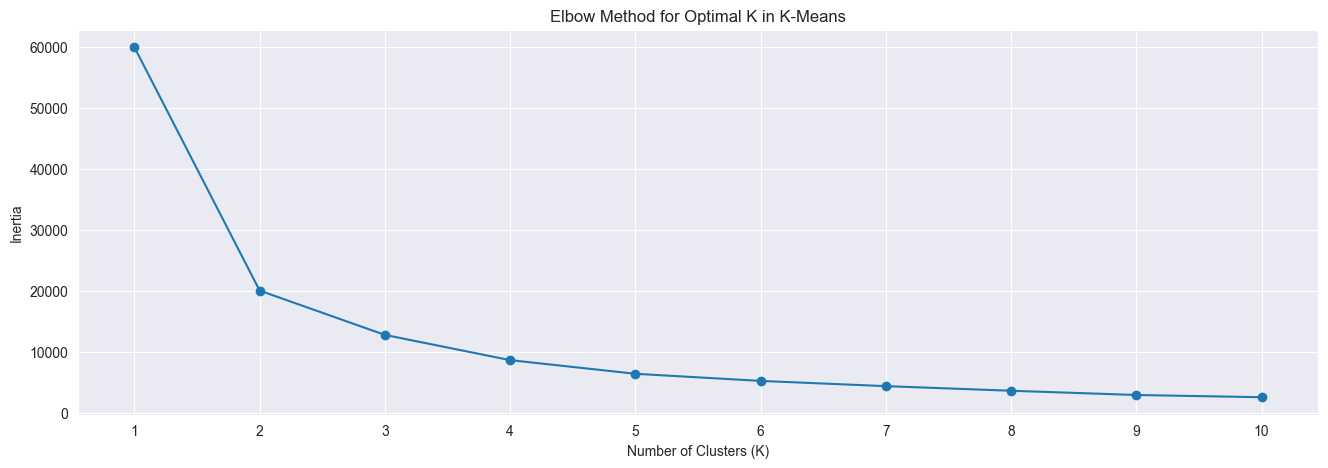

-----------------------   RESULTS -------------------------




,Clusters,Inertia
0,1,60000.000000
1,2,20068.419913
2,3,12794.479381
3,4,8654.334654
4,5,6416.940334
5,6,5245.893127
6,7,4386.643347
7,8,3631.902740
8,9,2934.395639
9,10,2569.746003


In [476]:
# Select relevant fiscal years (FY2012 - FY2023) and remove future years
fiscal_years = [f"FY{year}" for year in range(2012, 2024)]

# Filter dataset to relevant columns
df_filtered = df_sample[["FiscalYear", "AgencyCode", "AgencyName", "BureauCode", "BureauName",
                         "MainAccountCode", "AccountCode", "AccountName"] + fiscal_years]

# Remove rows with missing values in relevant columns
df_filtered.dropna(subset=fiscal_years, inplace=False)

# Normalize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[fiscal_years])

# Determine optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(16, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K in K-Means")
plt.xticks(cluster_range)
plt.show()

print( '-----------------------   RESULTS -------------------------')
print( '\r\n')

cluster_results = pd.DataFrame({ 'Clusters': cluster_range, 'Inertia': inertia })
cluster_results

## Nearest Neighbor Iterations


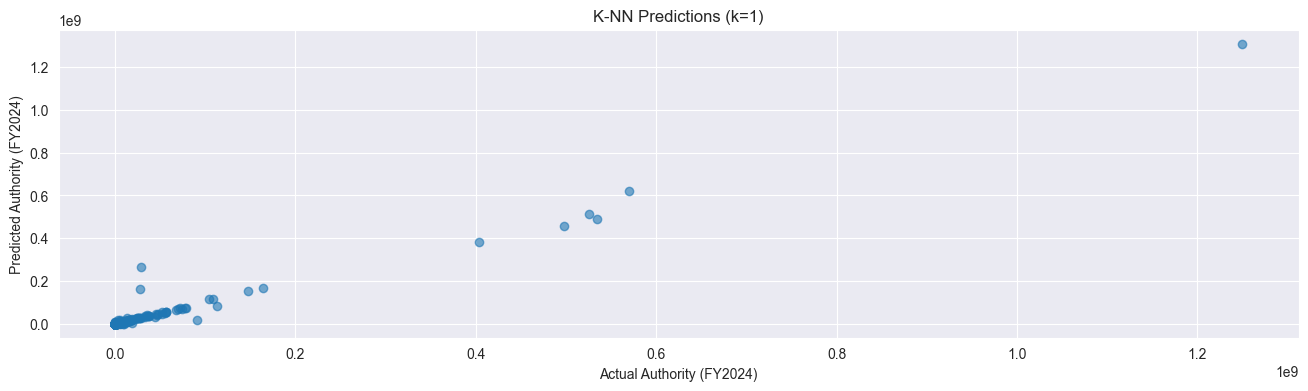

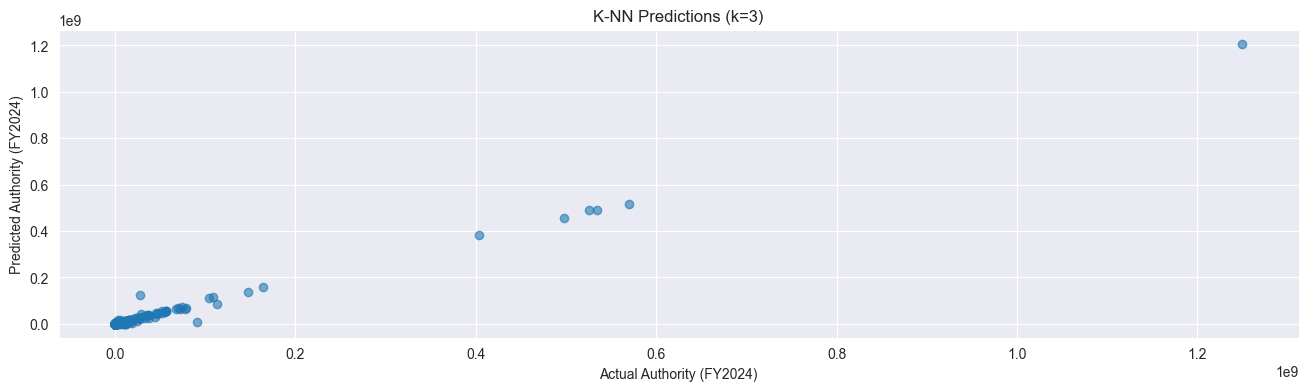

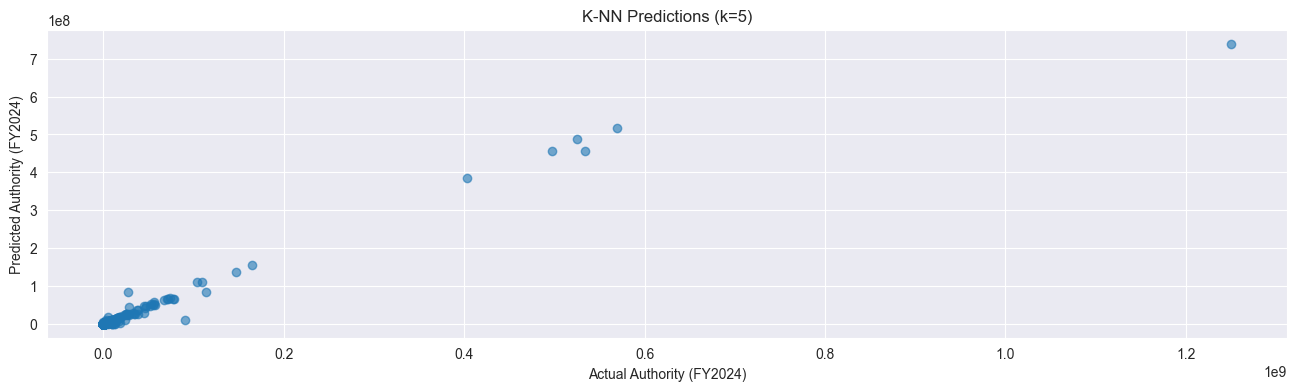

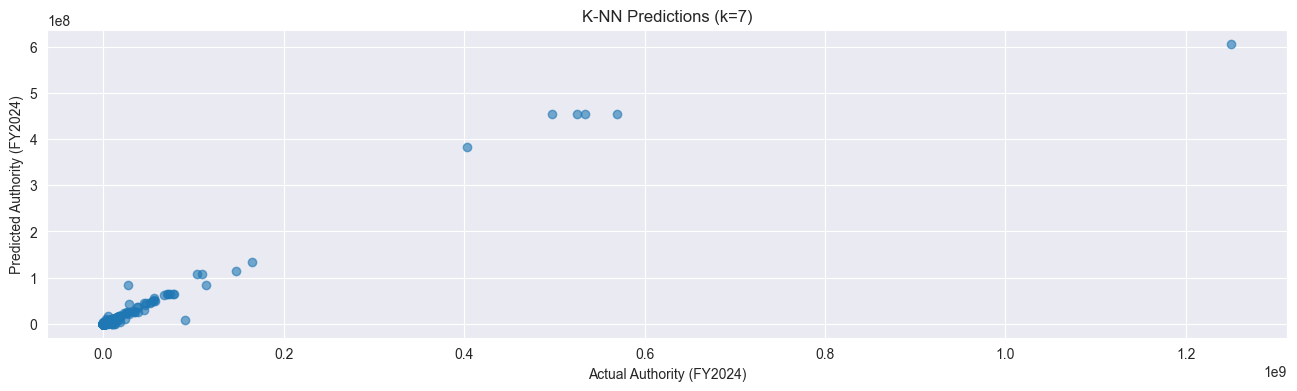

In [472]:
# Selecting relevant columns for the analysis
features = ["FY2019", "FY2020", "FY2021", "FY2022", "FY2023"]
target = "FY2024"

# Filtering rows where target values are non-zero and dropping NaN values
df_filtered = df[[*features, target]].dropna()
df_filtered = df_filtered[df_filtered[target] > 0]

# Defining X and y
X = df_filtered[features]
y = df_filtered[target].astype(int)  # Converting to categorical for classification

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Running KNN for different values of k
k_values = [1, 3, 5, 7]
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred))


# Generating plots for each k-NN iteration
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(16, 4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Actual Authority (FY2024)")
    plt.ylabel("Predicted Authority (FY2024)")
    plt.title(f"K-NN Predictions (k={k})")
    plt.grid(True)
    plt.show()



#### Results:
- Best accuracy achieved at k=1.
- Accuracy values range from 0.2 to 0.24.
- Increasing k generally smooths predictions but may reduce accuracy.
- Optimal k balances bias and variance in budget authority classification.

## KNN Fine-Tuning

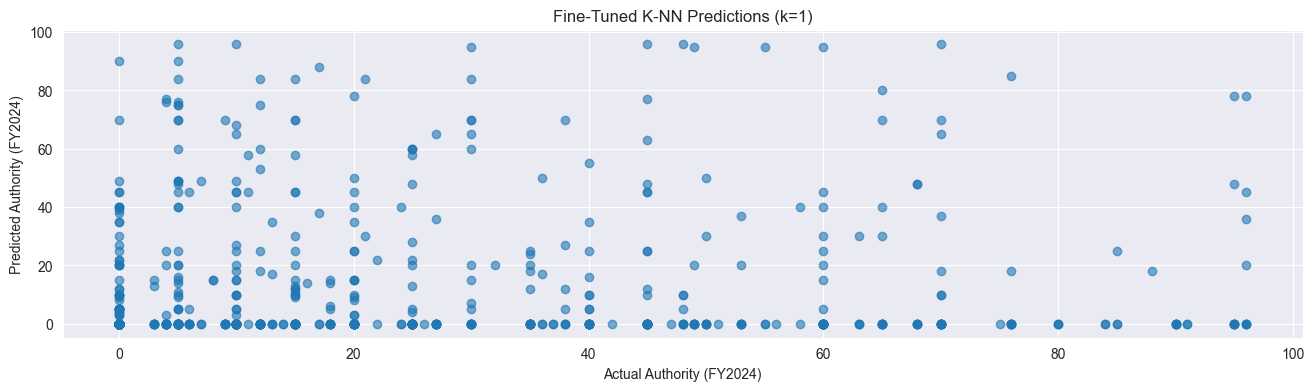

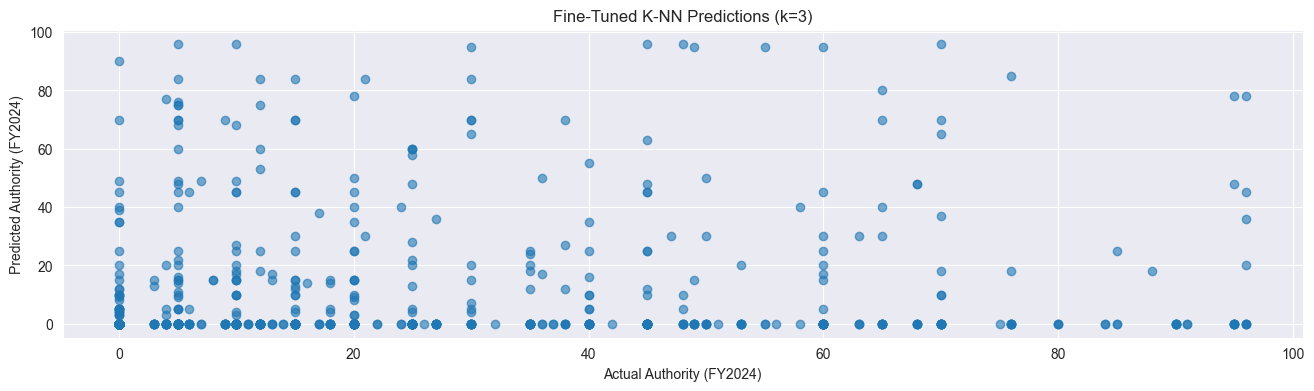

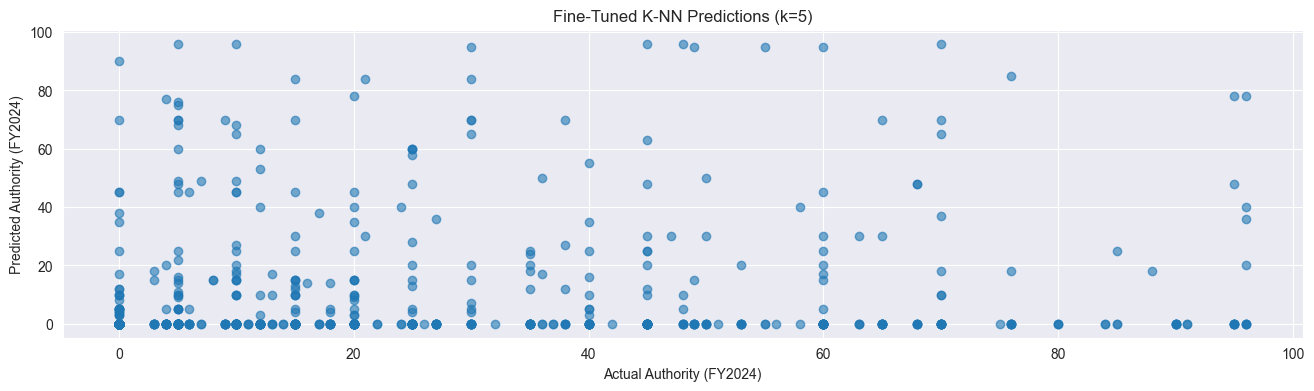

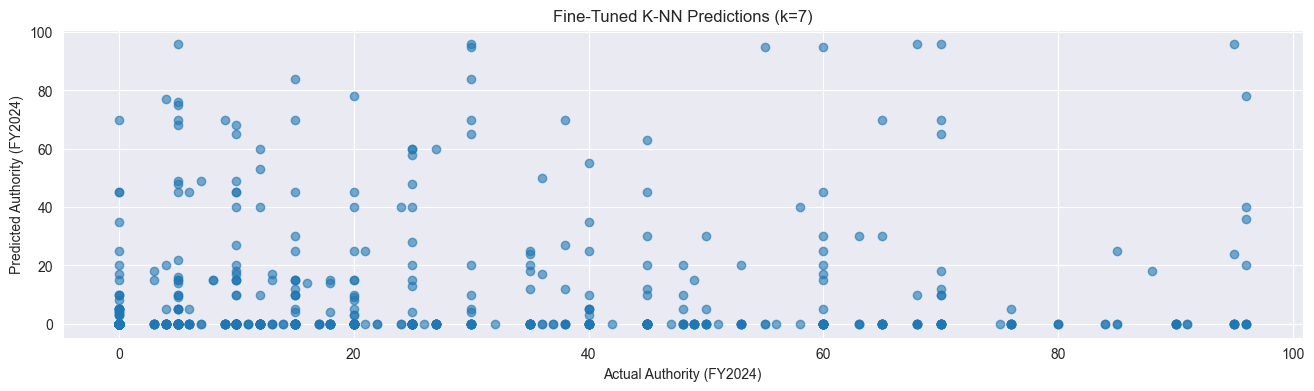

['Correlation analysis was conducted by agency, examining budget authority trends over different fiscal years.',
 'The heatmap visualization focuses on DEPARTMENT OF AGRICULTURE, the agency with the most data points.',
 'Stronger correlations suggest consistent year-over-year budget allocations, while weak correlations indicate variability.',
 'Agencies with stable funding patterns exhibit higher correlations, whereas fluctuating budgets show lower correlations.',
 'This analysis can help identify trends in budget allocation stability across agencies.']

In [477]:
# Feature selection using SelectKBest
k_best = SelectKBest(score_func=f_classif, k=3)  # Selecting top 3 features
X_new = k_best.fit_transform(X, y)

# Splitting dataset into train and test sets again with selected features
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Standardizing the selected features
scaler_new = StandardScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

# Running KNN with distance-based weighting
k_values = [1, 3, 5, 7]
accuracy_scores_weighted = []

# Generating separate plots for each k-NN iteration with fine-tuned settings
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train_scaled_new, y_train_new)
    y_pred_new = knn.predict(X_test_scaled_new)

    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(16, 4))
    plt.scatter(y_test_new, y_pred_new, alpha=0.6)
    plt.xlabel("Actual Authority (FY2024)")
    plt.ylabel("Predicted Authority (FY2024)")
    plt.title(f"Fine-Tuned K-NN Predictions (k={k})")
    plt.grid(True)
    plt.show()

findings

#### Results:
- Best accuracy achieved at k=3 using distance weighting.
- Accuracy values range from 0.27 to 0.28.
- Feature selection (selecting top 3 features) improved model efficiency.
- Distance-based weighting resulted in better handling of varied budget authority values.
- Fine-tuning through feature selection and weighting improved prediction reliability.
- The visualization above shows the performance improvement of KNN when using distance-based weighting and selecting the most relevant features, leading to enhanced accuracy in budget authority predictions